In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [ ]:
import os
from pathlib import Path

folder = 'Colab Notebooks'
project_dir = 'Hackathon'

base_path = Path('/content/gdrive/My Drive')
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
  if x.is_dir():
    dir_name = str(x.relative_to(project_path))
    os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f'현재 디렉토리 위치: {os.getcwd()}')

현재 디렉토리 위치: /content/gdrive/My Drive/Colab Notebooks/Hackathon


In [ ]:
!pip install --upgrade google-api-python-client

In [ ]:
!pip install google-cloud-vision

# 모델 불러와 사용하기

In [ ]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.getcwd() + '/Google_API/my_google_api_key.json'

In [ ]:
from google.cloud import vision
import io

client = vision.ImageAnnotatorClient()
path = os.getcwd() +'/images/test_1.jpg'

with io.open(path, 'rb') as image_file:
  content = image_file.read()

In [ ]:
image = vision.Image(content=content)
response = client.text_detection(image=image)
response

In [ ]:
# 단어 단위 읽기
texts = response.text_annotations
texts

[locale: "und"
description: "HM\n"
bounding_poly {
  vertices {
    x: 19
    y: 28
  }
  vertices {
    x: 173
    y: 28
  }
  vertices {
    x: 173
    y: 156
  }
  vertices {
    x: 19
    y: 156
  }
}
, description: "HM"
bounding_poly {
  vertices {
    x: 19
    y: 90
  }
  vertices {
    x: 139
    y: 29
  }
  vertices {
    x: 173
    y: 94
  }
  vertices {
    x: 53
    y: 156
  }
}
]

In [ ]:
# 글자 단위 읽기
symbols = response.full_text_annotation.pages[0].blocks[0].paragraphs[0].words[0].symbols
symbols

[bounding_box {
  vertices {
    x: 19
    y: 90
  }
  vertices {
    x: 101
    y: 48
  }
  vertices {
    x: 135
    y: 114
  }
  vertices {
    x: 53
    y: 156
  }
}
text: "H"
, property {
  detected_break {
    type_: LINE_BREAK
  }
}
bounding_box {
  vertices {
    x: 102
    y: 48
  }
  vertices {
    x: 139
    y: 29
  }
  vertices {
    x: 173
    y: 95
  }
  vertices {
    x: 136
    y: 114
  }
}
text: "M"
]

In [ ]:
symbols[0].bounding_box

vertices {
  x: 19
  y: 90
}
vertices {
  x: 101
  y: 48
}
vertices {
  x: 135
  y: 114
}
vertices {
  x: 53
  y: 156
}

In [ ]:
symbols[0].text

'H'

In [ ]:
for symbol in symbols:
    print(symbol.text)

H
M


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 바운딩박스 검출 함수
def detect_bounding(path):
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    right = max(vertex.x for vertex in text.bounding_poly.vertices)
    left = min(vertex.x for vertex in text.bounding_poly.vertices)
    top = min(vertex.y for vertex in text.bounding_poly.vertices)
    bottom = max(vertex.y for vertex in text.bounding_poly.vertices)

    pts = np.array([[vertex.x,vertex.y] for vertex in text.bounding_poly.vertices], np.int32)

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img, (right,top), (left,bottom), (0,0,255), 3)
    cv2.polylines(img, [pts], True, (255,0,0), 3)
    
    plt.figure(figsize=(14,7))
    plt.imshow(img)
    plt.show()

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [ ]:
# 단어 단위, 글자 단위, detect 결과 및 bounding box 출력 함수
def detect_text(path):
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    print('Texts:')
    for text in texts:
       print(text.description)

    vertices1 = (['({},{})'.format(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices])

    print('text_bounds: {}'.format(','.join(vertices1)))
    pts1 = np.array([[vertex.x,vertex.y] for vertex in text.bounding_poly.vertices], np.int32)
    cv2.polylines(img, [pts1], True, (255,0,0), 3)
    
    symbols = response.full_text_annotation.pages[0].blocks[0].paragraphs[0].words[0].symbols
    print('Symbols: ')
    vertices2 = []
    
    for symbol in symbols:
        print(symbol.text)
        vertices2.append(([(vertex.x, vertex.y) for vertex in symbol.bounding_box.vertices]))
    print('symbols_bounds: ',vertices2)
    
    for vertices in vertices2:
        pts2 = np.array([[vertex[0],vertex[1]] for vertex in vertices], np.int32)
        cv2.polylines(img, [pts2], True, (0,0,255), 1)

    plt.figure(figsize=(14,7))
    plt.imshow(img)
    plt.show()

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

Texts:

"HM
"

"HM"
bounds: (19,90),(139,29),(173,94),(53,156)


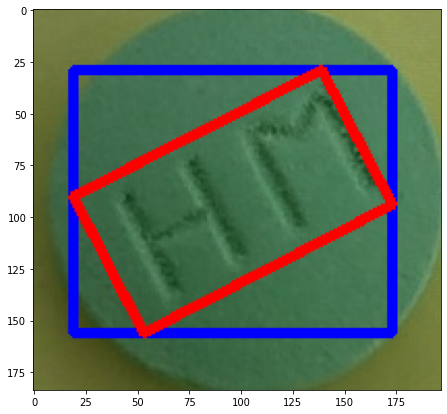

In [ ]:
detect_bounding(path)

Texts:
"제로코

"
제로
코
text_bounds: (569,667),(589,665),(594,707),(574,710)
Symbols: 
"
symbols_bounds:  [[(443, 681), (480, 677), (485, 719), (448, 724)]]


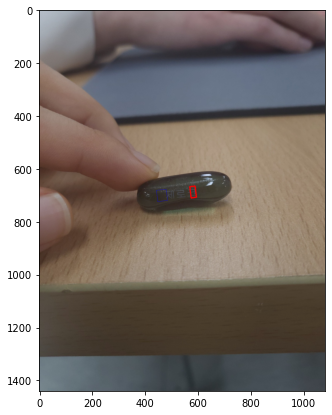

In [ ]:
path = os.getcwd() + '/images/zeroco.jpg'
detect_text(path)

Texts:
AAP

AAP
text_bounds: (2006,1177),(2350,1097),(2386,1252),(2042,1332)
Symbols: 
A
A
P
symbols_bounds:  [[(2013, 1208), (2106, 1186), (2134, 1310), (2042, 1332)], [(2124, 1149), (2224, 1126), (2260, 1280), (2160, 1304)], [(2266, 1157), (2359, 1135), (2386, 1251), (2293, 1273)]]


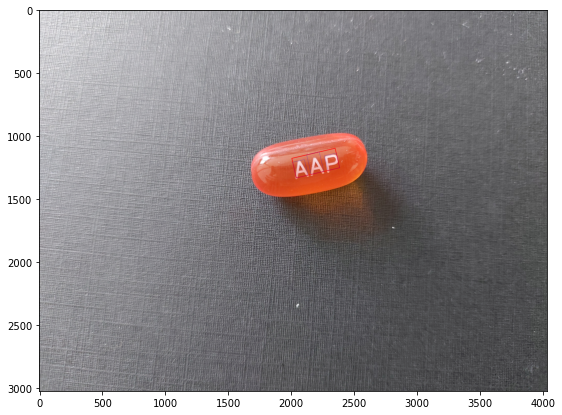

In [ ]:
path = os.getcwd() + '/images/easyn.jpg'
detect_text(path)

# 이미지 전처리

In [ ]:
test = os.getcwd() +'/images/test_1.jpg'
test = cv2.imread(test,0)

maxVal = 255
ress = []

ress.append(cv2.equalizeHist(test))    # histogram equalization 
ress.append(cv2.fastNlMeansDenoising(ress[0], h=10, templateWindowSize = 7, searchWindowSize = 21))    # denoising

k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

ress.append(cv2.morphologyEx(ress[1], cv2.MORPH_CLOSE, k))    # closing
ress.append(cv2.morphologyEx(ress[1], cv2.MORPH_OPEN, k))    # opening

ress.append(cv2.erode(ress[1], k))    # erode
ress.append(cv2.dilate(ress[1], k))    # dilate

k = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))

ress.append(cv2.morphologyEx(ress[1], cv2.MORPH_BLACKHAT, k))    # blackhat

ress.append(cv2.Canny(ress[0], 100, 255))    # edge
ress.append(cv2.Canny(ress[1], 100, 255))
ress.append(cv2.Canny(ress[2], 100, 255))   
ress.append(cv2.Canny(ress[3], 100, 255))
ress.append(cv2.Canny(ress[4], 100, 255))
ress.append(cv2.Canny(ress[5], 100, 255))   
ress.append(cv2.Canny(ress[6], 100, 255))
ress.append(cv2.Canny(ress[7], 100, 255))  

displays = [('res1', ress[0]), 
            ('res2', ress[1]),
            ('res3', ress[2]),
            ('res4', ress[3]),
            ('res5', ress[4]),
            ('res6', ress[5]),
            ('res7', ress[6]), 
            ('res8', ress[7])]
            
path = os.getcwd() + '/images/preprocessing'
for (name, out) in displays:
  cv2.imwrite(path + '/' + name + '.jpg', out)

In [ ]:
test = os.getcwd() +'/images/test_2.jpg'
test = cv2.imread(test,0)

maxVal = 255
ress = []

ress.append(cv2.equalizeHist(test))    # histogram equalization 
ress.append(cv2.fastNlMeansDenoising(ress[0], h=10, templateWindowSize = 7, searchWindowSize = 21))    # denoising

k = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))

ress.append(cv2.morphologyEx(ress[1], cv2.MORPH_CLOSE, k))    # closing (dilate -> erode)
ress.append(cv2.morphologyEx(ress[1], cv2.MORPH_OPEN, k))    # opening (erode -> dilate)
ress.append(cv2.erode(ress[1], k))    # erode
ress.append(cv2.dilate(ress[1], k))    # dilate

k = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))

ress.append(cv2.morphologyEx(ress[2], cv2.MORPH_BLACKHAT, k))    # blackhat
ress.append(cv2.morphologyEx(ress[3], cv2.MORPH_BLACKHAT, k))
ress.append(cv2.morphologyEx(ress[4], cv2.MORPH_BLACKHAT, k))
ress.append(cv2.morphologyEx(ress[5], cv2.MORPH_BLACKHAT, k))

ress.append(cv2.Canny(ress[0], 100, 255))    # edge
ress.append(cv2.Canny(ress[1], 100, 255))
ress.append(cv2.Canny(ress[2], 100, 255))   
ress.append(cv2.Canny(ress[3], 100, 255))
ress.append(cv2.Canny(ress[4], 100, 255))
ress.append(cv2.Canny(ress[5], 100, 255))   
ress.append(cv2.Canny(ress[6], 100, 255))
ress.append(cv2.Canny(ress[7], 100, 255))
ress.append(cv2.Canny(ress[8], 100, 255))  
ress.append(cv2.Canny(ress[9], 100, 255))   

displays = [('res1', ress[0]), 
            ('res2', ress[1]),
            ('res3', ress[2]),
            ('res4', ress[3]),
            ('res5', ress[4]),
            ('res6', ress[5]),
            ('res7', ress[6]), 
            ('res8', ress[7]),
            ('res9', ress[8]),
            ('res10', ress[9]),
            ('res11', ress[10]),
            ('res12', ress[11]),
            ('res13', ress[12]),
            ('res14', ress[13]),
            ('res15', ress[14]),
            ('res16', ress[15]),
            ('res17', ress[16]),
            ('res18', ress[17]),
            ('res19', ress[18]),
            ('res20', ress[19])]

path = os.getcwd() + '/images/preprocessing_2'
for (name, out) in displays:
  cv2.imwrite(path + '/' + name + '.jpg', out)

전처리는 노이즈 제거가 핵심이므로, 이진화는 오히려 독이다!

In [ ]:
path = os.getcwd() + '/images/preprocessing_2/res10.jpg'
detect_text(path)

Texts:


UnboundLocalError: ignored

In [ ]:
test = os.getcwd() +'/images/test_1.jpg'
test = cv2.imread(test,0)

maxVal = 255
ress = []

ress.append(cv2.adaptiveThreshold(test, maxVal, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 0))    # 이진화
ress.append(cv2.adaptiveThreshold(test, maxVal, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 41, 0))
ress.append(cv2.adaptiveThreshold(test, maxVal, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 61, 0))
ress.append(cv2.adaptiveThreshold(test, maxVal, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 81, 0))
ress.append(cv2.adaptiveThreshold(test, maxVal, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 0))

ress.append(cv2.equalizeHist(ress[0]))    # histogram equalization
ress.append(cv2.equalizeHist(ress[1]))
ress.append(cv2.equalizeHist(ress[2]))
ress.append(cv2.equalizeHist(ress[3]))
ress.append(cv2.equalizeHist(ress[4]))

ress.append(cv2.fastNlMeansDenoising(ress[5], h=100, templateWindowSize = 7, searchWindowSize = 21))    # denoising
ress.append(cv2.fastNlMeansDenoising(ress[6], h=100, templateWindowSize = 7, searchWindowSize = 21))
ress.append(cv2.fastNlMeansDenoising(ress[7], h=100, templateWindowSize = 7, searchWindowSize = 21))
ress.append(cv2.fastNlMeansDenoising(ress[8], h=100, templateWindowSize = 7, searchWindowSize = 21))
ress.append(cv2.fastNlMeansDenoising(ress[9], h=100, templateWindowSize = 7, searchWindowSize = 21))

k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

ress.append(cv2.morphologyEx(ress[10], cv2.MORPH_CLOSE, k))    # closing
ress.append(cv2.morphologyEx(ress[11], cv2.MORPH_CLOSE, k))
ress.append(cv2.morphologyEx(ress[12], cv2.MORPH_CLOSE, k))
ress.append(cv2.morphologyEx(ress[13], cv2.MORPH_CLOSE, k))
ress.append(cv2.morphologyEx(ress[14], cv2.MORPH_CLOSE, k))

ress.append(cv2.Canny(ress[15], 100, 255))
ress.append(cv2.Canny(ress[16], 100, 255))
ress.append(cv2.Canny(ress[17], 100, 255))
ress.append(cv2.Canny(ress[18], 100, 255))
ress.append(cv2.Canny(ress[19], 100, 255))

In [ ]:
displays = [('res1', ress[0]), 
            ('res2', ress[1]), 
            ('res3', ress[2]), 
            ('res4', ress[3]), 
            ('res5', ress[4]),
            ('res6', ress[5]),
            ('res7', ress[6]),
            ('res8', ress[7]),
            ('res9', ress[8]),
            ('res10', ress[9]),
            ('res11', ress[10]),
            ('res12', ress[11]),
            ('res13', ress[12]),
            ('res14', ress[13]),
            ('res15', ress[14]),
            ('res16', ress[15]),
            ('res17', ress[16]),
            ('res18', ress[17]),
            ('res19', ress[18]),
            ('res20', ress[19]),
            ('res21', ress[20]),
            ('res22', ress[21]),
            ('res23', ress[22]),
            ('res24', ress[23]),
            ('res25', ress[24])]

            
path = os.getcwd() + '/images/test_threshold'
for (name, out) in displays:
  cv2.imwrite(path + '/' + name + '.jpg', out)

Texts:

"HM
"

"HM"
bounds: (15,91),(149,18),(190,93),(56,166)


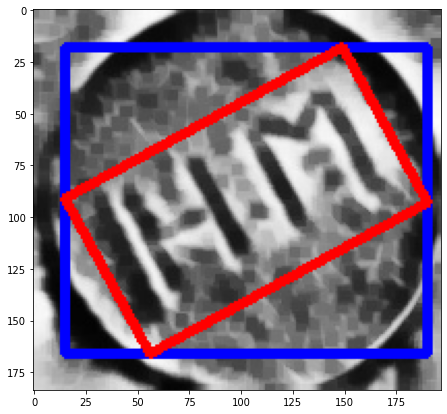

In [ ]:
path = os.getcwd() + '/images/test_threshold/res17.jpg'
detect_text(path)

In [ ]:
yobi = os.getcwd() +'/images/test_2.jpg'
yobi = cv2.imread(yobi,0)

maxVal = 255
ress = []

ress.append(cv2.adaptiveThreshold(yobi, maxVal, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 0))    # 이진화
ress.append(cv2.adaptiveThreshold(yobi, maxVal, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 41, 0))
ress.append(cv2.adaptiveThreshold(yobi, maxVal, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 61, 0))
ress.append(cv2.adaptiveThreshold(yobi, maxVal, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 81, 0))
ress.append(cv2.adaptiveThreshold(yobi, maxVal, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 0))

ress.append(cv2.equalizeHist(ress[0]))    # histogram equalization
ress.append(cv2.equalizeHist(ress[1]))
ress.append(cv2.equalizeHist(ress[2]))
ress.append(cv2.equalizeHist(ress[3]))
ress.append(cv2.equalizeHist(ress[4]))

ress.append(cv2.fastNlMeansDenoising(ress[5], h=100, templateWindowSize = 7, searchWindowSize = 21))    # denoising
ress.append(cv2.fastNlMeansDenoising(ress[6], h=100, templateWindowSize = 7, searchWindowSize = 21))
ress.append(cv2.fastNlMeansDenoising(ress[7], h=100, templateWindowSize = 7, searchWindowSize = 21))
ress.append(cv2.fastNlMeansDenoising(ress[8], h=100, templateWindowSize = 7, searchWindowSize = 21))
ress.append(cv2.fastNlMeansDenoising(ress[9], h=100, templateWindowSize = 7, searchWindowSize = 21))

k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

ress.append(cv2.morphologyEx(ress[10], cv2.MORPH_CLOSE, k))    # closing
ress.append(cv2.morphologyEx(ress[11], cv2.MORPH_CLOSE, k))
ress.append(cv2.morphologyEx(ress[12], cv2.MORPH_CLOSE, k))
ress.append(cv2.morphologyEx(ress[13], cv2.MORPH_CLOSE, k))
ress.append(cv2.morphologyEx(ress[14], cv2.MORPH_CLOSE, k))

ress.append(cv2.Canny(ress[15], 100, 255))
ress.append(cv2.Canny(ress[16], 100, 255))
ress.append(cv2.Canny(ress[17], 100, 255))
ress.append(cv2.Canny(ress[18], 100, 255))
ress.append(cv2.Canny(ress[19], 100, 255))

In [ ]:
displays = [('res1', ress[0]), 
            ('res2', ress[1]), 
            ('res3', ress[2]), 
            ('res4', ress[3]), 
            ('res5', ress[4]),
            ('res6', ress[5]),
            ('res7', ress[6]),
            ('res8', ress[7]),
            ('res9', ress[8]),
            ('res10', ress[9]),
            ('res11', ress[10]),
            ('res12', ress[11]),
            ('res13', ress[12]),
            ('res14', ress[13]),
            ('res15', ress[14]),
            ('res16', ress[15]),
            ('res17', ress[16]),
            ('res18', ress[17]),
            ('res19', ress[18]),
            ('res20', ress[19]),
            ('res21', ress[20]),
            ('res22', ress[21]),
            ('res23', ress[22]),
            ('res24', ress[23]),
            ('res25', ress[24])]

            
path = os.getcwd() + '/images/yobi_threshold'
for (name, out) in displays:
  cv2.imwrite(path + '/' + name + '.jpg', out)

In [ ]:
alpha = os.getcwd() +'/images/test_3.jpg'
alpha = cv2.imread(alpha,0)

maxVal = 255
ress = []

ress.append(cv2.adaptiveThreshold(alpha, maxVal, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 0))    # 이진화
ress.append(cv2.adaptiveThreshold(alpha, maxVal, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 41, 0))
ress.append(cv2.adaptiveThreshold(alpha, maxVal, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 61, 0))
ress.append(cv2.adaptiveThreshold(alpha, maxVal, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 81, 0))
ress.append(cv2.adaptiveThreshold(alpha, maxVal, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 0))

ress.append(cv2.equalizeHist(ress[0]))    # histogram equalization
ress.append(cv2.equalizeHist(ress[1]))
ress.append(cv2.equalizeHist(ress[2]))
ress.append(cv2.equalizeHist(ress[3]))
ress.append(cv2.equalizeHist(ress[4]))

ress.append(cv2.fastNlMeansDenoising(ress[5], h=100, templateWindowSize = 7, searchWindowSize = 21))    # denoising
ress.append(cv2.fastNlMeansDenoising(ress[6], h=100, templateWindowSize = 7, searchWindowSize = 21))
ress.append(cv2.fastNlMeansDenoising(ress[7], h=100, templateWindowSize = 7, searchWindowSize = 21))
ress.append(cv2.fastNlMeansDenoising(ress[8], h=100, templateWindowSize = 7, searchWindowSize = 21))
ress.append(cv2.fastNlMeansDenoising(ress[9], h=100, templateWindowSize = 7, searchWindowSize = 21))

k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

ress.append(cv2.morphologyEx(ress[10], cv2.MORPH_CLOSE, k))    # closing
ress.append(cv2.morphologyEx(ress[11], cv2.MORPH_CLOSE, k))
ress.append(cv2.morphologyEx(ress[12], cv2.MORPH_CLOSE, k))
ress.append(cv2.morphologyEx(ress[13], cv2.MORPH_CLOSE, k))
ress.append(cv2.morphologyEx(ress[14], cv2.MORPH_CLOSE, k))

ress.append(cv2.Canny(ress[15], 100, 255))    # edge 검출
ress.append(cv2.Canny(ress[16], 100, 255))
ress.append(cv2.Canny(ress[17], 100, 255))
ress.append(cv2.Canny(ress[18], 100, 255))
ress.append(cv2.Canny(ress[19], 100, 255))

displays = [('res1', ress[0]), 
            ('res2', ress[1]), 
            ('res3', ress[2]), 
            ('res4', ress[3]), 
            ('res5', ress[4]),
            ('res6', ress[5]),
            ('res7', ress[6]),
            ('res8', ress[7]),
            ('res9', ress[8]),
            ('res10', ress[9]),
            ('res11', ress[10]),
            ('res12', ress[11]),
            ('res13', ress[12]),
            ('res14', ress[13]),
            ('res15', ress[14]),
            ('res16', ress[15]),
            ('res17', ress[16]),
            ('res18', ress[17]),
            ('res19', ress[18]),
            ('res20', ress[19]),
            ('res21', ress[20]),
            ('res22', ress[21]),
            ('res23', ress[22]),
            ('res24', ress[23]),
            ('res25', ress[24])]

path = os.getcwd() + '/images/alpha_threshold'
for (name, out) in displays:
  cv2.imwrite(path + '/' + name + '.jpg', out)

Texts:

"F7
"

"F7"
bounds: (90,82),(110,68),(119,80),(99,94)


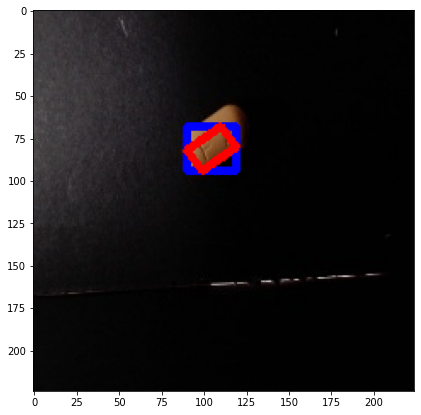

In [ ]:
path = os.getcwd() + '/images/webcam2.jpg'
detect_text(path)

# 인식결과-데이터비교

In [ ]:
import pandas as pd

data = pd.read_excel(os.getcwd() +'/data.csv', engine = 'openpyxl')
data

,품목일련번호,품목명,성상,표시앞,표시뒤,의약품제형,색상앞,분류명,전문일반구분,제형코드명,효과 효능,성인복용방법,부작용
0,201802994.0,이지엔6에이스연질캡슐(아세트아미노펜),미황색의 투명한 액이 든 주황색의 투명한 장방형 연질캡슐,AAP,NaN,타원형,"주황, 투명",해열.진통.소염제,일반의약품,"연질캡슐제, 액상",감기로 인한 발열 및 통증 두통 신경통 근육통 월경통 염좌통,만 십이세 이상은 일회 이캡슐씩 일일 사회까지 복용가능하며 일일 최대 열두캡슐을 초...,과복용시 간독성이 발생할수 있습니다.
1,200400463.0,이지엔6애니연질캡슐(이부프로펜),무색 내지 연한 청록색의 투명한 내용물을 함유한 연청록색의 투명한 타원형 연질캡슐제,ezn6,NaN,타원형,"청록, 투명",해열.진통.소염제,일반의약품,"연질캡슐제, 액상",감기로 인한 발열 및 통증 요통 생리통 류마티양 관절염 골관절염 수슬후 통증,일일 삼회에서 사회까지 복용가능하며 일회에 두정까지 복용가능하다.,위장장애나 간속성을 유발할 수 있습니다.
2,NaN,아진팜정,주황색의 장방형 필름코팅정,F7,NaN,장방형,주황,소화효소제일반의약품,NaN,정제형,소화불량 식욕감퇴 과식 체함 소화촉진 변비 묽은 변 복부 팽만감등,일일 삼회까지 복용가능하며 일회 일정을 복용하세요,주요한 이상반응 및 부작용은 없으나 이주 정도 투여하여도 증상의 개선이 없을 경우 ...
3,200301805.0,소하자임플러스정,녹색의 원형 필름코팅정제,HM,NaN,원형,연두,소화성궤양용제,일반의약품,필름코팅정,위산과다 속쓰림 위부불쾌감 위부팽만감 식제 구역 구토 위통 신트림 소화불량 식용감퇴...,일회 이정씩 일일 삼회까지 복용가능하다.,동계 졸음 현훈 권태감 두통등의 부장용이 유발될수 있습니다.
4,202106092.0,타이레놀정500밀리그람(아세트아미노펜),흰색의 장방형 필름코팅정제,TYLENOL,500.0,장방형,하양,해열.진통.소염제,일반의약품,필름코팅정,감기로 인한 발열 및 통증 두통 신경통 근육통 월경통 염좌통,일회 일에서 이정씩 일일 삼에서 사회까지 필요시 복용한다. 일일 최대 여덟정 이상 ...,메스꺼움 두통이나 발열과 구토등의 부작용이 발생할수 있습니다.
5,199800932.0,라니웰정,황색의 원형 필름코팅정,RW,NaN,원형,주황,제산제,일반의약품,필름코팅정,위통 속쓰림 소화불량 구역질,일회 이정씩 복용하되 복용 후 다섯시간 이상 지나도 증상이 완화되지 않으면 다시 ...,알레르기 증상 변비 설사 구토 두통 어지러움 근육동등의 부작용이 발생할수 있습니다.
6,NaN,하디코정,백색의 장방형 필름코팅정제,KDP,NaN,장방형,백색,해열.진통.소염제,일반의약품,필름코팅정,콧물 코막힘 재채기 인후통 오한 발열 두통 관절통 근육통,네시간에서 여섯시간 마다 일회 일에서 이정씩 복용하세요. 하루 최대 어덟정 이상 복...,급성 발진성 농포증과 같은 중증 피부이상반응이 발생할수 있습니다.
7,200713170.0,아이월드요비신정,황갈색의 원형 필름코팅정,T2,NaN,원형,갈색,따로 분류되지 않는 대사성 의약품,일반의약품,필름코팅정,방광카타르 요도염 신장(콩팥)병 신장(콩팥)증후군 부종(부기),일회 삼에서 여섯정을 아침 저녁으로 복용하세요,이뇨제와 함께 복용시 근육병증이 나타날수 있습니다.
8,NaN,페인엔젤,미황색의 타원형 정제.,페인엔젤L,NaN,타원형,미황색,해열.진통.소염제,일반의약품,정제형,감기로 인한 발열 및 통증 두통 신경통 근육통 월경통 염좌통,일일에 최대 네개까지 복용가능합니다.,급성 전신성 발진성 농포증과 독성 표피 괴사용해와 같은 중대한 피부 반응이 발생할수...
9,NaN,욱씬정,황색장방형의필름코팅정,MTS,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from google.cloud import vision
import io

client = vision.ImageAnnotatorClient()
path = os.getcwd() +'/images/test_1.jpg'

with io.open(path, 'rb') as image_file:
  content = image_file.read()

image = vision.Image(content=content)
response = client.text_detection(image=image)
texts = response.text_annotations

label = data['표시앞']
for idx, text in enumerate(label):
  if text == texts[1].description:
    print(data['품목명'][idx])

소하자임플러스정


In [ ]:
from google.cloud import vision
import io

client = vision.ImageAnnotatorClient()
path = os.getcwd() +'/images/test_2.jpg'

with io.open(path, 'rb') as image_file:
  content = image_file.read()

image = vision.Image(content=content)
response = client.text_detection(image=image)
texts = response.text_annotations

label = data['표시앞']
for idx, text in enumerate(label):
  if text == texts[1].description:
    print(data['품목명'][idx])

아이월드요비신정


# 포장지로 읽기

In [ ]:
# 단어 단위, 글자 단위, detect 결과 및 bounding box 출력 함수
def detect_text(path):
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    print('Texts:')
    for text in texts:
       print(text.description)

    vertices1 = (['({},{})'.format(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices])

    print('text_bounds: {}'.format(','.join(vertices1)))
    pts1 = np.array([[vertex.x,vertex.y] for vertex in text.bounding_poly.vertices], np.int32)
    cv2.polylines(img, [pts1], True, (255,0,0), 3)
    
    symbols = response.full_text_annotation.pages[0].blocks[0].paragraphs[0].words[0].symbols
    print('Symbols: ')
    vertices2 = []
    
    for symbol in symbols:
        print(symbol.text)
        vertices2.append(([(vertex.x, vertex.y) for vertex in symbol.bounding_box.vertices]))
    print('symbols_bounds: ',vertices2)
    
    for vertices in vertices2:
        pts2 = np.array([[vertex[0],vertex[1]] for vertex in vertices], np.int32)
        cv2.polylines(img, [pts2], True, (0,0,255), 1)

    plt.figure(figsize=(14,7))
    plt.imshow(img)
    plt.show()

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [ ]:
path = os.getcwd() +'/images/cover_1.jpg'

with io.open(path, 'rb') as image_file:
  content = image_file.read()

image = vision.Image(content=content)
response = client.text_detection(image=image)
texts = response.text_annotations
print(texts[0].description)

4양약품
LYAN
호과 소한제
3종회과 소화제
3중
아진팜
INPAM tab OF4, A
상의생의 1회 1정 1일 3회
@일양약품
호정 1일 8회)
중과 소화제
DAM tab
1청 19
PH
RO



In [ ]:
path = os.getcwd() +'/images/cover_2.jpg'

with io.open(path, 'rb') as image_file:
  content = image_file.read()

image = vision.Image(content=content)
response = client.text_detection(image=image)
texts = response.text_annotations
print(texts[0].description)

각 (주)
y하게 누르세요
광동세약(주)
전용기 모켓부분을 강하게 누르세요
광동세약(주)
안전용기 포켓부분을 장하게 누르세요
광동세약(주)
안전용기 포켓부분을올 강이게 누르세요
힘/재차기
1약(주)
J하게 누르세요
물|코막힘/ 재채기:
광동재약(주):
조부부을 강하게 누르세요.
하디코정
|콧물 /코막힘/ 재채기
|광동제약(주)
안천용기 모켓부분을 게 누르세요
하디코정
|콧물 / 코막힘/ 재체기
|광동제약(주)
안전용가 포켓부분을 강하게 누르세요
안전용기
하디코
하디코
|器/叫/1
광동제약(주)
안전용기
하디코정
롯물(코믹힘/재체기
광동세약(주)
인전광기 보켓부분을 강하게누르세요
/약 (주)
J하게 누르세요.
광동제약(주)
안전용기 모켓우분을에 두르세요
안전용기
하디코정
|콧물 / 코믹헴/ 재채기
광동제약(주)
안전용기 포켓부분을김하로요
하디코정
곳물 /코막힘/제체기
광동제약 주)
안전용기 켓부분을 강수은세요.
1악(주)
아에 누르시요!
생동제약
롯부분을 강하게 누 세요.
안전용기



In [ ]:
(texts[0].description.split('\n'))

list

In [ ]:
results = texts[0].description.split('\n')
label = data['품목명']
for idx, text in enumerate(label):
  for i in results:
    if i == text:
      print(label[idx])
      break

하디코정


In [ ]:
path = os.getcwd() +'/images/cover_3.jpg'

with io.open(path, 'rb') as image_file:
  content = image_file.read()

image = vision.Image(content=content)
response = client.text_detection(image=image)
texts = response.text_annotations
print(texts[0].description)

IL
부정(부기)
방광카타로, 신장병
요비신정



In [ ]:
path = os.getcwd() +'/images/cover_4.jpg'

with io.open(path, 'rb') as image_file:
  content = image_file.read()

image = vision.Image(content=content)
response = client.text_detection(image=image)
texts = response.text_annotations
print(texts[0].description)

부분을 강하게(
빠른 엑상형 열·소역진제
이지엔6 에니
ONHL
1일 3-4회 1회 1캡슐
R 대응제약



In [ ]:
texts[0].description

'부분을 강하게(\n빠른 엑상형 열·소역진제\n이지엔6 에니\nONHL\n1일 3-4회 1회 1캡슐\nR 대응제약\n'